# Forecasting Electricity Consumption with Support Vector Regression

This iPython notebook composed by Justin Elszasz.

This notebook describes the process of training a support vector regression model for predicting electricity consumption based on several weather variables, the hour of the day, and whether the day was a weekend/holiday/work-from-home-day or just a normal weekday.

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# some nice colors - like Dad always said, it's better to look good than to be good

gray_light = '#d4d4d2'
gray_med = '#737373'
red_orange = '#ff3700'

In [6]:
# Import the BGE hourly electricity data and weather data using import_funcs.py class
elec = pd.read_csv('data/elec_hourly_oldApt_2014-04-30.csv', parse_dates=True, index_col=0)
weather = pd.read_csv('data/weather_2015-02-01.csv', parse_dates=True, index_col=0)

# Merge into one Pandas dataframe
elec_and_weather = pd.merge(weather, elec, left_index=True, right_index=True)

# Remove unnecessary fields from dataframe
del elec_and_weather['tempm'], elec_and_weather['COST'], elec_and_weather['UNITS']
del elec_and_weather['precipm']

# Convert windspeed to MPH for my feeble brain to interpret
elec_and_weather['wspdMPH'] = elec_and_weather['wspdm'] * 0.62
del elec_and_weather['wspdm']

elec_and_weather.head()

,hum,tempF,USAGE,timestamp_end,wspdMPH
timestamp,,,,,
2014-01-18 00:00:00,56,39.2,1.13,2014-01-18 00:59:00,4.588
2014-01-18 01:00:00,61,39.2,0.98,2014-01-18 01:59:00,4.588
2014-01-18 02:00:00,61,39.2,0.94,2014-01-18 02:59:00,4.588
2014-01-18 03:00:00,65,39.2,1.11,2014-01-18 03:59:00,4.588
2014-01-18 04:00:00,70,39.2,1.34,2014-01-18 04:59:00,4.588


I want to distinguish typical weekdays from any weekends, holidays and days I worked from home.  I don't think any of those categories have enough of their own examples in order to qualify them as their own set so for now all normal weekdays are 0, all holidays, weekends, and work-from-home days are 1's.  

In [8]:
# Set weekends and holidays to 1, otherwise 0
elec_and_weather['Atypical_Day'] = np.zeros(len(elec_and_weather['USAGE']))

# Weekends
elec_and_weather['Atypical_Day'][(elec_and_weather.index.dayofweek==5)|(elec_and_weather.index.dayofweek==6)] = 1

# Holidays, days I worked from home
holidays = ['2014-01-01','2014-01-20']
work_from_home = ['2014-01-21','2014-02-13','2014-03-03','2014-04-04']

for i in range(len(holidays)):
    elec_and_weather['Atypical_Day'][elec_and_weather.index.date==np.datetime64(holidays[i])] = 1

for i in range(len(work_from_home)):
    elec_and_weather['Atypical_Day'][elec_and_weather.index.date==np.datetime64(work_from_home[i])] = 1
    
elec_and_weather.head(3)

/Users/Justin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Justin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Justin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,hum,tempF,USAGE,timestamp_end,wspdMPH,Atypical_Day
timestamp,,,,,,
2014-01-18 00:00:00,56,39.2,1.13,2014-01-18 00:59:00,4.588,1
2014-01-18 01:00:00,61,39.2,0.98,2014-01-18 01:59:00,4.588,1
2014-01-18 02:00:00,61,39.2,0.94,2014-01-18 02:59:00,4.588,1


For this case each hour of the day is a categorical variable, not continuous. The doing the analysis will require "yes" or "no" corresponding to each hour of the day.

In [9]:
# Create new column for each hour of day, assign 1 if index.hour is corresponding hour of column, 0 otherwise

for i in range(0,24):
    elec_and_weather[i] = np.zeros(len(elec_and_weather['USAGE']))
    elec_and_weather[i][elec_and_weather.index.hour==i] = 1
    
# Example 3am
elec_and_weather[3][:3]

/Users/Justin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


timestamp
2014-01-18 00:00:00    0
2014-01-18 01:00:00    0
2014-01-18 02:00:00    0
Name: 3, dtype: float64

If I want to predict the next hour's energy consumption, any given X vector/Y target pair in the training data should provide the current hour's electricity use (target) with the previous hour's (or however many past hours are used) weather data and usage (X vector).

In [10]:
%time
# Add historic usage to each X vector

# Set number of hours prediction is in advance
n_hours_advance = 1

# Set number of historic hours used
n_hours_window = 12

# need to do this for range function
#n_hours_window += 1

for k in range(n_hours_advance,n_hours_advance+n_hours_window):
    
    elec_and_weather['USAGE_t-%i'% k] = np.zeros(len(elec_and_weather['USAGE']))
    #elec_and_weather['tempF_t-%i'% k] = np.zeros(len(elec_and_weather['tempF']))
    #elec_and_weather['hum_t-%i'% k] = np.zeros(len(elec_and_weather['hum']))
    #elec_and_weather['wspdMPH_t-%i'% k] = np.zeros(len(elec_and_weather['wspdMPH']))
    
    
for i in range(n_hours_advance+n_hours_window,len(elec_and_weather['USAGE'])):
    
    for j in range(n_hours_advance,n_hours_advance+n_hours_window):
        
        elec_and_weather['USAGE_t-%i'% j][i] = elec_and_weather['USAGE'][i-j]
        #elec_and_weather['tempF_t-%i'% j][i] = elec_and_weather['tempF'][i-j]
        #elec_and_weather['wspdMPH_t-%i'% j][i] = elec_and_weather['wspdMPH'][i-j]
        #elec_and_weather['hum_t-%i'% j][i] = elec_and_weather['hum'][i-j]

elec_and_weather = elec_and_weather.ix[n_hours_advance+n_hours_window:]
        
elec_and_weather.head(3)


/Users/Justin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,hum,tempF,USAGE,timestamp_end,wspdMPH,Atypical_Day,0,1,2,3,...,USAGE_t-3,USAGE_t-4,USAGE_t-5,USAGE_t-6,USAGE_t-7,USAGE_t-8,USAGE_t-9,USAGE_t-10,USAGE_t-11,USAGE_t-12
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-18 13:00:00,75,37.4,1.60,2014-01-18 13:59:00,4.588,1,0,0,0,0,...,1.54,1.56,1.44,1.26,1.33,1.16,1.34,1.11,0.94,0.98
2014-01-18 14:00:00,75,37.4,1.68,2014-01-18 14:59:00,4.588,1,0,0,0,0,...,1.87,1.54,1.56,1.44,1.26,1.33,1.16,1.34,1.11,0.94
2014-01-18 15:00:00,60,37.4,1.43,2014-01-18 15:59:00,4.588,1,0,0,0,0,...,1.88,1.87,1.54,1.56,1.44,1.26,1.33,1.16,1.34,1.11


Since this is time series data, it makes more sense to define training and testing periods, rather than random sporadic data points.  If it weren't a time series, we could select a random sample to segregate for a testing set.  

In [11]:
# Define training and testing periods

train_start = '18-jan-2014'
train_end = '24-march-2014'
test_start = '25-march-2014'
test_end = '31-march-2014'


In [12]:
from sklearn import svm
from sklearn import cross_validation
from sklearn import preprocessing as pre

In [28]:
# Set up dataframes for building SVR model

# Need to keep only the t-1 variables for predicting the next hour
X_train_df = elec_and_weather[train_start:train_end]
del X_train_df['USAGE']
del X_train_df['timestamp_end']
#del X_train_df['hum']
#del X_train_df['tempF']
del X_train_df['wspdMPH']

y_train_df = elec_and_weather['USAGE'][train_start:train_end]

X_test_df = elec_and_weather[test_start:test_end]
del X_test_df['USAGE']
del X_test_df['timestamp_end']
#del X_test_df['hum']
#del X_test_df['tempF']
del X_test_df['wspdMPH']

y_test_df = elec_and_weather['USAGE'][test_start:test_end]

In [29]:
X_train_df.to_csv('output/training_set.csv')

In [30]:
N_train = len(X_train_df[0])
print X_train_df[:5], N_train


                     hum  tempF  Atypical_Day  0  1  2  3  4  5  6  \
timestamp                                                            
2014-01-18 13:00:00   75   37.4             1  0  0  0  0  0  0  0   
2014-01-18 14:00:00   75   37.4             1  0  0  0  0  0  0  0   
2014-01-18 15:00:00   60   37.4             1  0  0  0  0  0  0  0   
2014-01-18 16:00:00   56   35.6             1  0  0  0  0  0  0  0   
2014-01-18 17:00:00   56   35.6             1  0  0  0  0  0  0  0   

                        ...      USAGE_t-3  USAGE_t-4  USAGE_t-5  USAGE_t-6  \
timestamp               ...                                                   
2014-01-18 13:00:00     ...           1.54       1.56       1.44       1.26   
2014-01-18 14:00:00     ...           1.87       1.54       1.56       1.44   
2014-01-18 15:00:00     ...           1.88       1.87       1.54       1.56   
2014-01-18 16:00:00     ...           1.60       1.88       1.87       1.54   
2014-01-18 17:00:00     ...        

In [31]:
# Numpy arrays for sklearn
X_train = np.array(X_train_df)
X_test = np.array(X_test_df)
y_train = np.array(y_train_df)
y_test = np.array(y_test_df)

Preprocessing.  StandardScaler() from the "preprocessing" module in "sklearn" 

In [32]:
from sklearn import preprocessing as pre
scaler = pre.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

This trains the support vector regression model.

In [33]:
SVR_model = svm.SVR(kernel='rbf',C=100,gamma=.001).fit(X_train_scaled,y_train)
print 'Testing R^2 =', round(SVR_model.score(X_test_scaled,y_test),3)

Testing R^2 = 0.788


Calculate next-hour forecast (predict!)

In [34]:
# Use SVR model to calculate predicted next-hour usage
predict_y_array = SVR_model.predict(X_test_scaled)

# Put it in a Pandas dataframe for ease of use
predict_y = pd.DataFrame(predict_y_array,columns=['USAGE'])
predict_y.index = X_test_df.index

Plot time series of actual and predicted electricity demand over the testing period.

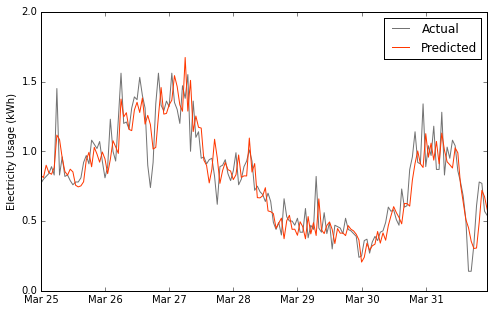

In [35]:
# Plot the predicted values and actual
import matplotlib.dates as dates

plot_start = test_start
plot_end = test_end

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
plt.plot(y_test_df.index,y_test_df,color=gray_med,linewidth=1)
plt.plot(predict_y.index,predict_y,color=red_orange,linewidth=1)
plt.ylabel('Electricity Usage (kWh)')
plt.ylim([0,2])
plt.legend(['Actual','Predicted'],loc='best')
ax.xaxis.set_major_formatter(dates.DateFormatter('%b %d'))

#fig.savefig('SVM_predict_TS.png')

Plot actual vs. prediced usage.  If prediction were perfect, all points would be on 45 degree line (y=x).


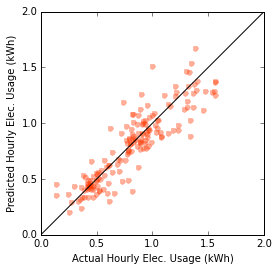

In [36]:
fig = plt.figure(figsize=(4,4))
plot = plt.plot(y_test_df,predict_y,color=red_orange,marker='.',linewidth=0,markersize=10,alpha=.4)
plot45 = plt.plot([0,2],[0,2],'k')
plt.xlim([0,2])
plt.ylim([0,2])
plt.xlabel('Actual Hourly Elec. Usage (kWh)')
plt.ylabel('Predicted Hourly Elec. Usage (kWh)')

#fig.savefig('SVM_plot_errors.png')

The following plots the time series of actual and predicted electricity demand for a given time period.

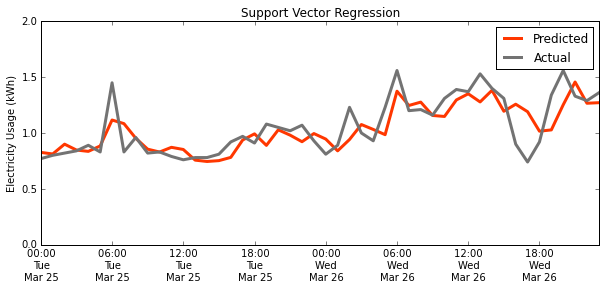

In [37]:
#plot_start = test_start
#plot_end = test_end
plot_start = '25-mar-2014 00:00:00'
plot_end = '26-mar-2014 23:00:00'
xticks = pd.date_range(start=plot_start, end=plot_end, freq='6H')

fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)
plot1 = plt.plot(predict_y[plot_start:plot_end].index,predict_y[plot_start:plot_end],color=red_orange,linewidth=3)
plot2 = plt.plot(y_test_df[plot_start:plot_end].index,y_test_df[plot_start:plot_end],color=gray_med,linewidth=3)
#plt_predict = plt.plot(predict_y[plot_start:plot_end].index,predict_y[plot_start:plot_end])
#plt_actual = plt.plot(y_test_df[plot_start:plot_end].index,y_test_df[plot_start:plot_end])
plt.ylabel('Electricity Usage (kWh)')
plt.ylim([0,2])
plt.xticks(xticks)
plt.title('Support Vector Regression')
plt.legend(['Predicted','Actual'],loc='best')
#ax.xaxis.set_major_locator()
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:00 \n%a \n%b %d'))
#dates.HourLocator(interval=12)


#fig.savefig('SVM_predict_TS_zoom.png')

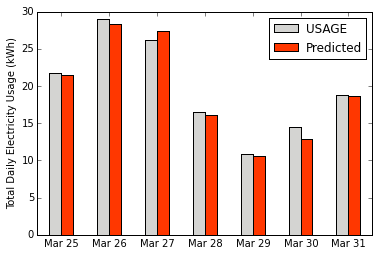

In [38]:
# Plot daily total kWh over testing period
y_test_barplot_df = pd.DataFrame(y_test_df,columns=['USAGE'])
y_test_barplot_df['Predicted'] = predict_y['USAGE']

fig = plt.figure()
ax = fig.add_subplot(111)
y_test_barplot_df.resample('d',how='sum').plot(kind='bar',ax=ax,color=[gray_light,red_orange])
ax.grid(False)
ax.set_ylabel('Total Daily Electricity Usage (kWh)')
ax.set_xlabel('')
# Pandas/Matplotlib bar graphs convert xaxis to floats, so need a hack to get datetimes back
ax.set_xticklabels([dt.strftime('%b %d') for dt in y_test_df.resample('d',how='sum').index.to_pydatetime()],rotation=0)
plt.show()
#fig.savefig('SVM_predict_DailyTotal.png')


The following are some accuracy measures.  These are moved to the file errors.py for ease of use.

In [39]:
import errors

N_test = len(y_test_df)
MBE = (y_test_df-predict_y).sum()/(N_test-1)/y_test_df.mean()
RMSE = pow(pow(y_test_df-predict_y,2).sum()/N_test,.5)
MAPE = ((y_test_df-predict_y).abs()/y_test_df).mean()
CV = pow(pow(y_test_df-predict_y,2).sum()/(N_test-1),.5)/y_test_df.mean()

print 'N_test = ',N_test,'\nMBE =',round(MBE['USAGE'],2),'\nRMSE =',round(RMSE['USAGE'],2),'\nMAPE =',round(MAPE['USAGE'],2),'\nCV =',round(CV['USAGE'],2)

N_test =  168 
MBE = 0.02 
RMSE = 0.15 
MAPE = 0.16 
CV = 0.19
